# Estimate the Cartesian field components from total-field anomaly

This code illustrates how to estimated the Cartesian magnetic field components from the approximated total-field anomaly produced by homogeneous rectangular prisms.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf
from gravmag import filters, convolve, transforms

### Model

In [2]:
# Create a model formed by prisms
model = np.array([[2000., 3000., -1500., -500., 10., 1010.], 
                  [1600., 2600., -2500., -1500., 10., 1010.], 
                  [-10000., 10000., 1500., 2500., 10., 1010.],
                  [-3000., -2000., -10000., 1500., 10., 1010.]])

# magnetization of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
h = 1
inc = -45
dec = 50
magnetization = np.array([[h, inc, dec],
                          [h, inc, dec],
                          [h, inc, dec],
                          [h, inc, dec]])

### Points were we compute the synthetic data

In [3]:
# number of points along x and y
shape = (100, 100)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# Grid spacing
dx = (area[1] - area[0])/(shape[0]-1)
dy = (area[3] - area[2])/(shape[1]-1)

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)
yp = np.ravel(yp)
xp = np.ravel(xp)
zp = np.zeros_like(yp) - 150

coordinates = np.vstack([xp, yp, zp])

### Main field

In [4]:
# reference point
yc, xc = 0, 1000

# polynomial function defining the inclination (degrees)
I0 = 60 - 1e-5*(xp-xc) + 3e-4*(yp-yc) + 1e-8*(xp-xc)*(xp-xc) + 1e-8*(yp-yc)*(yp-yc)

# polynomial function defining the declination (degrees)
D0 = 43 + 6e-5*(xp-xc) + 1e-4*(yp-yc) + 3e-9*(xp-xc)*(xp-xc) + 4e-9*(yp-yc)*(yp-yc)

# polynomial function defining the intensity (nT)
F0 = 23400 + 1e-3*(xp-xc) + 1e-3*(yp-yc) + 0*(xp-xc)*(xp-xc) + 0*(yp-yc)*(yp-yc)

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

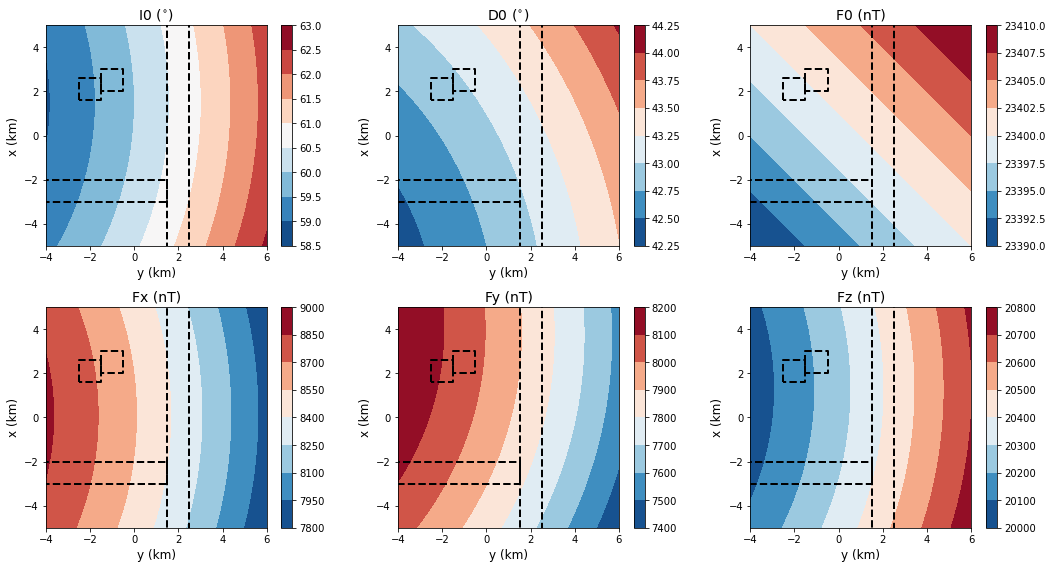

In [5]:
fields = [I0, D0, F0, Fx, Fy, Fz]
windows = [1, 2, 3, 4, 5, 6]
titles = ['I0 ($^{\circ}$)', 'D0 ($^{\circ}$)', 'F0 (nT)',
          'Fx (nT)', 'Fy (nT)', 'Fz (nT)']

plt.figure(figsize=(15,8))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.ylabel('x (km)', fontsize=12)
    plt.xlabel('y (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Synthetic data

In [6]:
# Compute the average main geomagnetic field on the simulated area 

mean_I0 = np.mean(I0)
mean_D0 = np.mean(D0)
cos_mean_I0 = np.cos(np.deg2rad(mean_I0))
sin_mean_I0 = np.sin(np.deg2rad(mean_I0))
cos_mean_D0 = np.cos(np.deg2rad(mean_D0))
sin_mean_D0 = np.sin(np.deg2rad(mean_D0))
Fx_hat = cos_mean_I0*cos_mean_D0
Fy_hat = cos_mean_I0*sin_mean_D0
Fz_hat = sin_mean_I0

In [7]:
# Compute the magnetic field components
bx = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_x')
by = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_y')
bz = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_z')

# Compute the total-field anomaly
tfa = np.sqrt((Fx+bx)**2 + (Fy+by)**2 + (Fz+bz)**2) - F0

# Compute the approximated total-field anomaly by using the
# average main field on the simulated area
approx_tfa = Fx_hat*bx + Fy_hat*by + Fz_hat*bz
diff_tfa = approx_tfa - tfa

### Estimate field components from the total-field anomaly (without approximation)

In [8]:
# 2D Fourier transform of the TFA
F_tfa = transforms.DFT(data=tfa.reshape(shape), pad_mode='linear_ramp')

# compute the wavenumbers
kx, ky, kz = transforms.wavenumbers(F_tfa.shape, dx, dy)

# compute the filter defining the main field direction in Fourier domain
main_field_filter = filters.direction(kx, ky, kz, mean_I0, mean_D0)

# main_field_filter[0,0] is zero and it causes a division-by-zero problem. 
# Because of that, we set main_field_filter[0,0] equal to 1
main_field_filter[0, 0] = 1.0

# compute the bx, by and bz components in Fourier 
FT_bx_tfa_fourier = convolve.compute(
    FT_data=F_tfa, 
    filters=[1./main_field_filter, 1j*kx]
)
FT_by_tfa_fourier = convolve.compute(
    FT_data=F_tfa, 
    filters=[1./main_field_filter, 1j*ky]
)
FT_bz_tfa_fourier = convolve.compute(
    FT_data=F_tfa, 
    filters=[1./main_field_filter, kz]
)

# 2D Inverse Fourier transform of the field components
bx_tfa_fourier = transforms.IDFT(FT_data=FT_bx_tfa_fourier, unpad=True, grid=False)
by_tfa_fourier = transforms.IDFT(FT_data=FT_by_tfa_fourier, unpad=True, grid=False)
bz_tfa_fourier = transforms.IDFT(FT_data=FT_bz_tfa_fourier, unpad=True, grid=False)

### Estimate field components from the approximated total-field anomaly

In [9]:
# 2D Fourier transform of the TFA
F_atfa = transforms.DFT(data=approx_tfa.reshape(shape), pad_mode='linear_ramp')

# compute the wavenumbers
#kx, ky, kz = transforms.wavenumbers(F_atfa.shape, dx, dy)

# compute the filter defining the main field direction in Fourier domain
#main_field_filter = filters.direction(kx, ky, kz, mean_I0, mean_D0)

# main_field_filter[0,0] is zero and it causes a division-by-zero problem. 
# Because of that, we set main_field_filter[0,0] equal to 1
#main_field_filter[0, 0] = 1.0

# compute the bx, by and bz components in Fourier 
FT_bx_atfa_fourier = convolve.compute(
    FT_data=F_atfa, 
    filters=[1./main_field_filter, 1j*kx]
)
FT_by_atfa_fourier = convolve.compute(
    FT_data=F_atfa, 
    filters=[1./main_field_filter, 1j*ky]
)
FT_bz_atfa_fourier = convolve.compute(
    FT_data=F_atfa, 
    filters=[1./main_field_filter, kz]
)

# 2D Inverse Fourier transform of the field components
bx_atfa_fourier = transforms.IDFT(FT_data=FT_bx_atfa_fourier, unpad=True, grid=False)
by_atfa_fourier = transforms.IDFT(FT_data=FT_by_atfa_fourier, unpad=True, grid=False)
bz_atfa_fourier = transforms.IDFT(FT_data=FT_bz_atfa_fourier, unpad=True, grid=False)

### Plot the data

In [10]:
field_names = ['bx', 'by', 'bz']
field_units = ['nT', 'nT', 'nT']

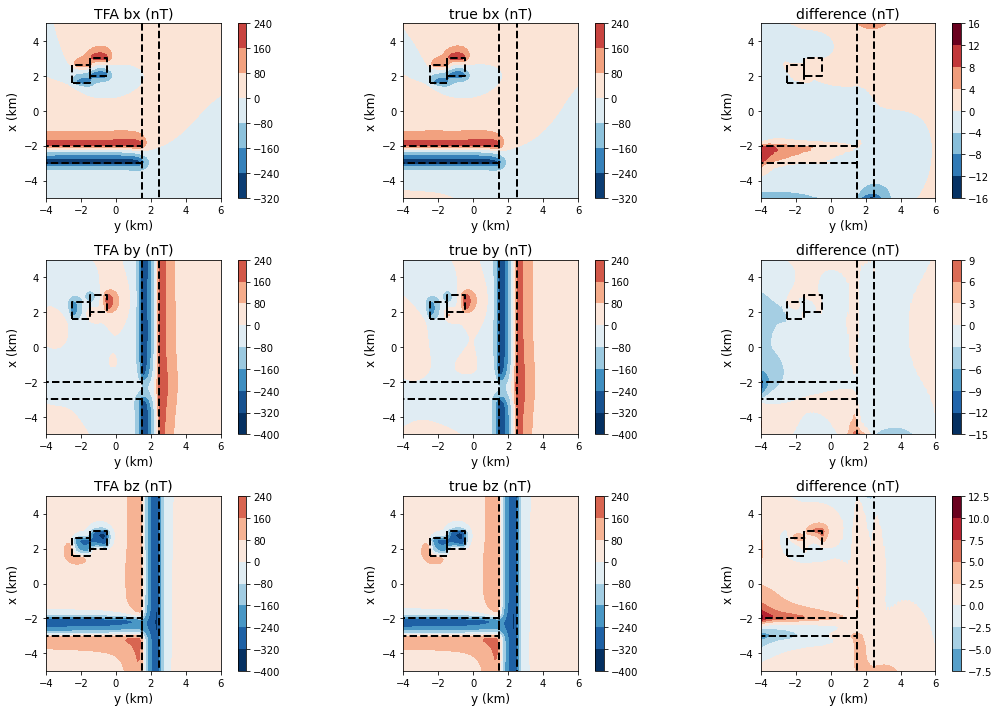

In [11]:
true_fields = [bx, by, bz]
predicted_fields = [bx_tfa_fourier, by_tfa_fourier, bz_tfa_fourier]

bounds, diffs = plf.bounds_diffs(predicted_fields, true_fields)

fields = plf.fields_list(predicted_fields, true_fields, diffs)

titles = []
for name, unit in zip(field_names, field_units):
    titles.append('TFA {} ({})'.format(name,unit))
    titles.append('true {} ({})'.format(name,unit))
    titles.append('difference ({})'.format(unit))

windows = [i for i in range(1,10)]

plt.figure(figsize=(15,10))

for w, window in enumerate(windows):

    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

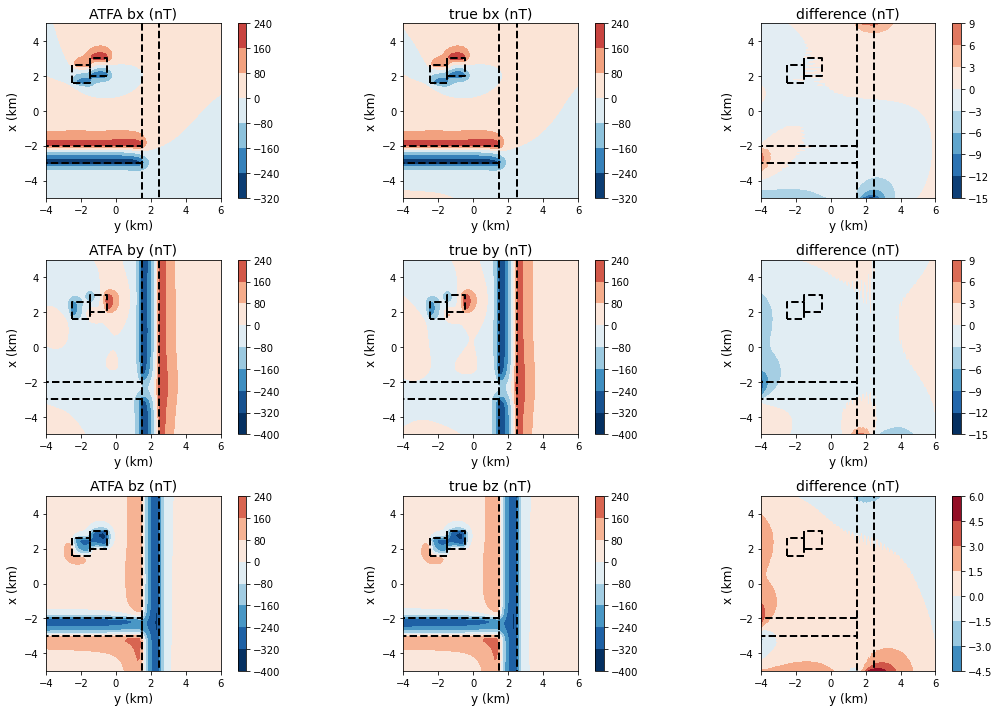

In [12]:
true_fields = [bx, by, bz]
predicted_fields = [bx_atfa_fourier, by_atfa_fourier, bz_atfa_fourier]

bounds, diffs = plf.bounds_diffs(predicted_fields, true_fields)

fields = plf.fields_list(predicted_fields, true_fields, diffs)

titles = []
for name, unit in zip(field_names, field_units):
    titles.append('ATFA {} ({})'.format(name,unit))
    titles.append('true {} ({})'.format(name,unit))
    titles.append('difference ({})'.format(unit))

windows = [i for i in range(1,10)]

plt.figure(figsize=(15,10))

for w, window in enumerate(windows):

    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()